# **Recap of [Lesson 6](https://colab.research.google.com/drive/1geSMNRkSwAelQJKd3e8vdoHCKiHMdmIo#forceEdit=true&sandboxMode=true) 👩‍💻🚀**

1. Learned how dlt works under the hood;
2. Explored 3 main steps:
  * Extract;
  * Normalize;
  * Load.
3. Learned which file formats dlt supports.

---

# **Inspecting & Adjusting Schema** 🧠🧠

**Here, you will learn or refresh your knowledge on:**
- Methods to inspect a schema
- The components of a schema
- How to modify a schema

---
##  **Methods to inspect a schema**

- **What's a schema?** The schema describes the structure of normalized data (e.g. tables, columns, data types, etc.). `dlt` generates schemas from the data during the normalization process.

- **How can you inspect a schema in `dlt`?** There are multiple ways:
  - CLI
  - Python
  - Export schema directly


Let's load some GitHub data to DuckDB to inspect the schema in different ways. First we need to install dlt with DuckDB:

In [1]:
%%capture
!pip install -U dlt

Define a dlt resource that fetches pull requests and wrap it in a dlt source, create a pipeline and run it:

In [2]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__SECRET_KEY"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(secret_key=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=secret_key),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_pulls(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls", params=params):
            yield page


    return github_pulls


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline1",
    destination="duckdb",
    dataset_name="github_data",
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline1 load step completed in 0.72 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline1.duckdb location to store data
Load package 1741702028.5312397 is LOADED and contains no failed jobs


---
### **(0) CLI**

Let's first try the CLI command `dlt pipeline -v <pipeline_name> load-package`, which is used to inspect a load package in verbose mode.

> In the context of the `dlt` library, a load package is a collection of jobs with data for particular tables. The -v flag stands for verbose, which means the command will provide more detailed output.

Specifically, this command will show the schema changes introduced in the load package for the given pipeline.

In [3]:
!dlt pipeline -v github_pipeline1 load-package

Attaching to pipeline github_pipeline1
Found pipeline github_pipeline1 in /var/dlt/pipelines
Package 1741702028.5312397 found in /var/dlt/pipelines/github_pipeline1/load/loaded/1741702028.5312397
The package with load id 1741702028.5312397 for schema github_source is in LOADED state. It updated schema for 9 tables. The package was LOADED at 2025-03-11 14:07:10.364139+00:00.
Jobs details:
Job: github_pulls__requested_reviewers.e44cc88280.insert_values, table: github_pulls__requested_reviewers in completed_jobs. File type: insert_values, size: 892B. Started on: 2025-03-11 14:07:09.608065+00:00 and completed in 0.76 seconds.
Job: github_pulls__assignees.c4f8eceefa.insert_values, table: github_pulls__assignees in completed_jobs. File type: insert_values, size: 1.2K. Started on: 2025-03-11 14:07:09.607065+00:00 and completed in 0.76 seconds.
Job: github_pulls__head__repo__topics.72bf05cc5e.insert_values, table: github_pulls__head__repo__topics in completed_jobs. File type: insert_values, si

---
### **(1) Python**

Alternatively, we can inspect the schema object from load info with:

```python
print(load_info.load_packages[0].schema)
```

which has the following public methods and attributes:

In [4]:
# This code snippet just prints out the public methods and attributes of the schema object in load info
all_attributes_methods = dir(load_info.load_packages[0].schema)
public_attributes_methods = [attr for attr in all_attributes_methods if not attr.startswith('_')]

print(f"{'Attribute/Method':<50} {'Type':<10}")
print("-" * 40)
for attr in public_attributes_methods:
    attr_value = getattr(load_info.load_packages[0].schema, attr)
    if callable(attr_value):
        print(f"{attr:<50} {'method':<10}")
    else:
        print(f"{attr:<50} {'attribute':<10}")

Attribute/Method                                   Type      
----------------------------------------
ENGINE_VERSION                                     attribute 
add_type_detection                                 method    
apply_schema_contract                              method    
clone                                              method    
coerce_row                                         method    
data_item_normalizer                               attribute 
data_table_names                                   method    
data_tables                                        method    
dlt_table_names                                    method    
dlt_tables                                         method    
drop_tables                                        method    
expand_schema_contract_settings                    method    
filter_row                                         method    
filter_row_with_hint                               method    
from_dict                    

Let's use the `to_pretty_json` method and print the schema:

In [5]:
print(load_info.load_packages[0].schema.to_pretty_json())

{
  "version": 2,
  "version_hash": "PFX9VoFpCl/AA3bY+A/mM1b/6V67woKy33y30GOZQLw=",
  "engine_version": 11,
  "name": "github_source",
  "tables": {
    "_dlt_version": {
      "columns": {
        "version": {
          "data_type": "bigint",
          "nullable": false
        },
        "engine_version": {
          "data_type": "bigint",
          "nullable": false
        },
        "inserted_at": {
          "data_type": "timestamp",
          "nullable": false
        },
        "schema_name": {
          "data_type": "text",
          "nullable": false
        },
        "version_hash": {
          "data_type": "text",
          "nullable": false
        },
        "schema": {
          "data_type": "text",
          "nullable": false
        }
      },
      "write_disposition": "skip",
      "resource": "_dlt_version",
      "description": "Created by DLT. Tracks schema updates"
    },
    "_dlt_loads": {
      "columns": {
        "load_id": {
          "data_type": "text",


---
### **(2) Exporting schema**

> Exporting the data schema directly into a file might be even more straightforward than the two previous approaches.

The instruction to export a schema should be provided at the beginning when creating a pipeline:

In [6]:
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline2",
    destination="duckdb",
    dataset_name="github_data",
    export_schema_path="schemas/export", # <--- dir path for a schema export
)

Run the pipeline:

In [7]:
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline2 load step completed in 0.67 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline2.duckdb location to store data
Load package 1741702071.7561743 is LOADED and contains no failed jobs


Check if the schema was exported.

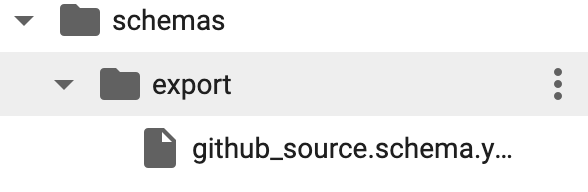

In [8]:
!ls schemas/export && cat schemas/export/github_source.schema.yaml

github_source.schema.yaml
version: 2
version_hash: PFX9VoFpCl/AA3bY+A/mM1b/6V67woKy33y30GOZQLw=
engine_version: 11
name: github_source
tables:
  _dlt_version:
    columns:
      version:
        data_type: bigint
        nullable: false
      engine_version:
        data_type: bigint
        nullable: false
      inserted_at:
        data_type: timestamp
        nullable: false
      schema_name:
        data_type: text
        nullable: false
      version_hash:
        data_type: text
        nullable: false
      schema:
        data_type: text
        nullable: false
    write_disposition: skip
    resource: _dlt_version
    description: Created by DLT. Tracks schema updates
  _dlt_loads:
    columns:
      load_id:
        data_type: text
        nullable: false
      schema_name:
        data_type: text
        nullable: true
      status:
        data_type: bigint
        nullable: false
      inserted_at:
        data_type: timestamp
        nullable: false
      schema_version

---
##  **The components of a schema**


> Since we learned the ways we can inspect the schema, it's important to actually understand what it contains to be able to meaningfully adjust it later.

A schema (in YAML format) looks somethng like this:

```yaml
version: 2
version_hash: wdIt+pExjT8Mj1ygQEMhq3E3SXtNBuIbHg0fDz9xD9I=
engine_version: 11
name: github_source
tables:
  _dlt_version:
    ...
  _dlt_loads:
    ...
  github_pulls:
    ...
settings:
  detections:
  - iso_timestamp
  default_hints:
    not_null:
    - _dlt_id
    - _dlt_root_id
    - _dlt_parent_id
    - _dlt_list_idx
    - _dlt_load_id
    parent_key:
    - _dlt_parent_id
    root_key:
    - _dlt_root_id
    unique:
    - _dlt_id
    row_key:
    - _dlt_id
normalizers:
  names: snake_case
  json:
    module: dlt.common.normalizers.json.relational
previous_hashes:
- 0WLnuf3Jh1J1XsbVrV2eB824Z6heOlf5o912i1v3tho=
- 0d1z0RFV2O0OvfEWkebtSjxrCjjiyv1lOeNiF0V8Lws=
```

---
### **(0) Schema version hash**

The schema hash, denoted by `version_hash`, is generated from the actual schema content, excluding the hash values and version of the schema.

Each time the schema is changed, a new hash is produced.

> Note that during the initial run (the first pipeline run), the version will be 2, and there will be two previous hashes because the schema is updated during both the extract and normalize stages. You can rely on the version number to determine how many times the schema has been changed, but keep in mind that it stops being reliable when parallelization is introduced.

Each version hash is then stored in the `_dlt_version` table.

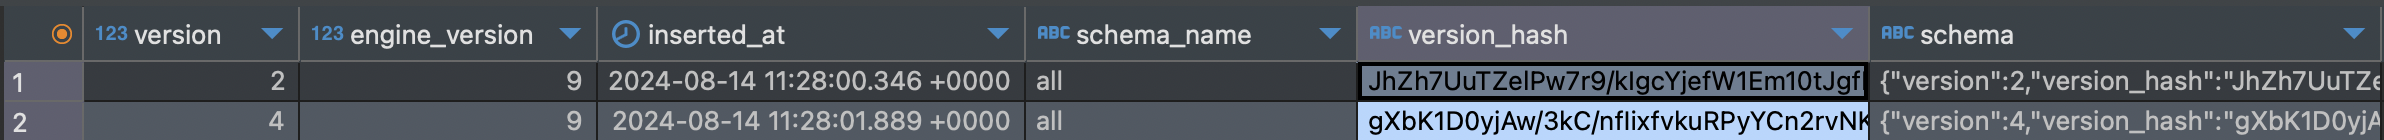

On subsequent runs, `dlt` checks if the generated schema hash is stored in this table. If it is not, `dlt` concludes that the schema has changed and migrates the destination accordingly.

- If multiple pipelines are sending data to the same dataset and there is a clash in table names, a single table with the union of the columns will be created.
- If columns clash and have different types or other incompatible characteristics, the load may fail if the data cannot be coerced.


---
### **(1) Naming convention**

Each schema contains a naming convention that is denoted in the following way when the schema is exported:

```yaml
...
normalizers:
  names: snake_case # naming convention
...
```
The naming convention is particularly useful if the identifiers of the data to be loaded (e.g., keys in JSON files) need to match the namespace of the destination (such as Redshift, which accepts case-insensitive alphanumeric identifiers with a maximum of 127 characters). This convention is used by `dlt` to translate between these identifiers and namespaces.

The standard behavior of `dlt` is to use the same naming convention for all destinations, ensuring that users always see the same tables and columns in their databases.

The default naming convention is `snake_case`:

- Removes all ASCII characters except alphanumerics and underscores.
- Adds an underscore (`_`) if the name starts with a number.
- Multiple underscores (`_`) are reduced to a single underscore.
- The parent-child relationship is expressed as a double underscore (`__`) in names.
- The identifier is shortened if it exceeds the length allowed at the destination.

> If you provide any schema elements that contain identifiers via decorators or arguments (e.g., `table_name` or `columns`), all the names used will be converted according to the naming convention when added to the schema. For example, if you execute `dlt.run(..., table_name="CamelCaseTableName")`, the data will be loaded into `camel_case_table_name`.

To retain the original naming convention, you can define the following in your `config.toml`:

```python
[schema]
naming="direct"
```

or use an environment variable as:

```
SCHEMA__NAMING=direct
```

---
### **(2) Schema settings**


The `settings` section of the schema file allows you to define various global rules that impact how tables and columns are inferred from data.

```yaml
settings:
  detections:
    ...
  default_hints:
    ...
```

**1. Detections**

You can define a set of functions that will be used to infer the data type of the column from a value. These functions are executed sequentially from top to bottom on the list.

```yaml
settings:
  detections:
    - timestamp # detects int and float values that can be interpreted as timestamps within a 5-year range and converts them
    - iso_timestamp # detects ISO 8601 strings and converts them to timestamp
    - iso_date #detects strings representing an ISO-like date (excluding timestamps) and, if so, converts to date
    - large_integer # detects integers too large for 64-bit and classifies as "wei" or converts to text if extremely large
    - hexbytes_to_text # detects HexBytes objects and converts them to text
    - wei_to_double # detects Wei values and converts them to double for aggregate non-financial reporting
```

>  `iso_timestamp` detector is enabled by default.

Detectors can be removed or added directly in code:

```python
  source = source()
  source.schema.remove_type_detection("iso_timestamp")
  source.schema.add_type_detection("timestamp")
```

**2. Column hint rules**

The `default_hints` section in the schema file is used to define global rules that apply to newly inferred columns.

> These rules are applied **after normalization**, meaning after the naming convention is applied!


By default, schema adopts column hint rules from the json(relational) normalizer to support correct hinting of columns added by the normalizer:

```yaml
settings:
  default_hints:
    foreign_key:
      - _dlt_parent_id
    not_null:
      - _dlt_id
      - _dlt_root_id
      - _dlt_parent_id
      - _dlt_list_idx
      - _dlt_load_id
    unique:
      - _dlt_id
    root_key:
      - _dlt_root_id
```


You can define column names with regular expressions as well.

```yaml
settings:
  default_hints:
  partition:
        - re:_timestamp$ #  add partition hint to all columns ending with _timestamp
```

Column hints can be added directly in code:

```python
  source = data_source()
  # this will update existing hints with the hints passed
  source.schema.merge_hints({"partition": ["re:_timestamp$"]})

```

**3. Preferred data types**

In the `preferred_types` section, you can define rules that will set the data type for newly created columns. On the left side, you specify a rule for a column name, and on the right side, you define the corresponding data type. You can use column names directly or with regular expressions to match them.

```yaml
settings:
  preferred_types:
    re:timestamp: timestamp
    inserted_at: timestamp
    created_at: timestamp
    updated_at: timestamp
```
Above, we prefer `timestamp` data type for all columns containing timestamp substring and define a exact matches for certain columns.

Preferred data types can be added directly in code as well:

```python
source = data_source()
source.schema.update_preferred_types(
  {
    "re:timestamp": "timestamp",
    "inserted_at": "timestamp",
    "created_at": "timestamp",
    "updated_at": "timestamp",
  }
)
```


---
##  **How to modify a schema**


Speaking of data types... you can directly apply data types and hints to your resources, bypassing the need for importing and adjusting schemas. This approach is ideal for rapid prototyping and handling data sources with dynamic schema requirements.

The two main approaches are:

- Using the `columns` argument in the `dlt.resource` decorator.
- Using the `apply_hints` method.

---
### **`(0) @dlt.resource(columns=...)`**

This code snippet sets up a nullable boolean column named `my_column` directly in the decorator.

```python
@dlt.resource(name='my_table', columns={"my_column": {"data_type": "bool", "nullable": True}})
def my_resource():
    for i in range(10):
        yield {'my_column': i % 2 == 0}
```

---
### **(1) `apply_hints`**

When dealing with dynamically generated resources or needing to programmatically set hints, `apply_hints` is your go-to tool.

The `apply_hints` method in dlt is used to programmatically **set** or **adjust** various aspects of your data resources or pipeline. It can be used in several ways:

* You can use `apply_hints` to **directly define data types** and their properties, such as nullability, within the `@dlt.resource` decorator. This eliminates the dependency on external schema files.

* When **dealing with dynamically generated resources** or needing to programmatically set hints, `apply_hints` is your tool. It's especially useful for applying hints across various collections or tables at once.

* `apply_hints` can be used to **load your data incrementally**. For example, you can load only files that have been updated since the last time dlt processed them, or load only the new or updated records by looking at a specific column.

* You can **set or update the table name, columns, and other schema elements** when your resource is executed, and you already yield data. Such changes will be merged with the existing schema in the same way the `apply_hints` method works.


It’s especially useful for applying hints across multiple collections or tables at once.

For example, to apply a complex data type across all collections from a MongoDB source:

```python
all_collections = ["collection1", "collection2", "collection3"]  # replace with your actual collection names
source_data = mongodb().with_resources(*all_collections)

for col in all_collections:
    source_data.resources[col].apply_hints(columns={"column_name": {"data_type": "complex"}})

pipeline = dlt.pipeline(
    pipeline_name="mongodb_pipeline",
    destination="duckdb",
    dataset_name="mongodb_data"
)
load_info = pipeline.run(source_data)
```

---
### **(2) Adjusting schema settings**

> Maybe you've noticed, but there several ways to adjust your schema settings directly in code were already covered. This is just a recap. You can go back directly to the Schema Settings section.

Detectors can be removed or added directly in code:

```python
  source = source()
  source.schema.remove_type_detection("iso_timestamp")
  source.schema.add_type_detection("timestamp")
```

Column hints can be added directly in code:

```python
  source = data_source()
  # this will update existing hints with the hints passed
  source.schema.merge_hints({"partition": ["re:_timestamp$"]})

```

Preferred data types can be added directly in code as well:

```python
source = data_source()
source.schema.update_preferred_types(
  {
    "re:timestamp": "timestamp",
    "inserted_at": "timestamp",
    "created_at": "timestamp",
    "updated_at": "timestamp",
  }
)
```


---
### **(3) Importing a schema**

> We mentioned that you can export a schema. In a similar fashion you can import a schema. The usual approach to use this functionaility is to export the schema first, make the adjustments and put the adjusted schema into the corresponding import folder.

The instruction to import a schema should be provided at the beginning when creating a pipeline:

In [10]:
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline3",
    destination="duckdb",
    dataset_name="github_data",
    export_schema_path="schemas/export",
    import_schema_path="schemas/import",
)

Let's make an initial pipeline run to export schema into the file.

In [11]:
# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_pipeline3 load step completed in 0.78 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_data
The duckdb destination used duckdb:////content/github_pipeline3.duckdb location to store data
Load package 1741702351.9656734 is LOADED and contains no failed jobs


Look at the "Files" in the left sidebar, see the `schema` folder, and `export` and `import` folders inside.


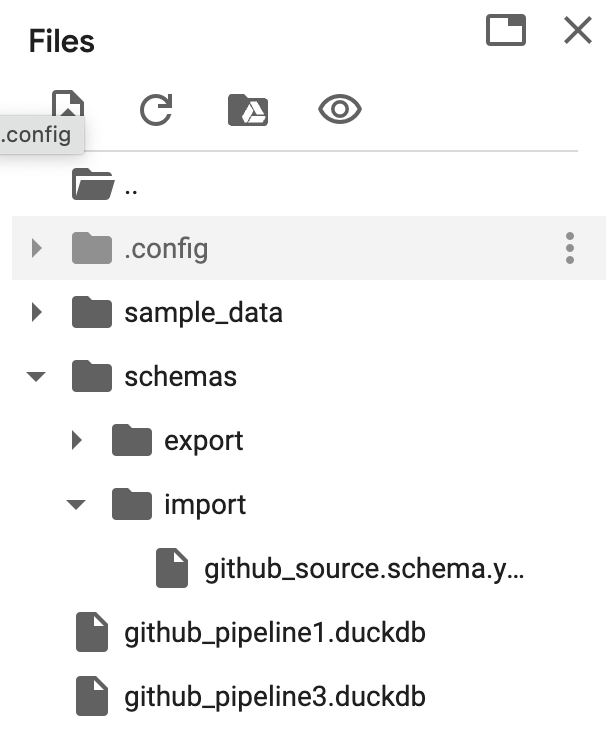

### Question

What **data type** does the column `version` in the `_dlt_version` table have?

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1jp5UtydA3x9cAq-fbW2tRmAOl4LMZqM1#forceEdit=true&sandboxMode=true)!

In [21]:
dataset = pipeline.dataset(dataset_type="default")
dataset._dlt_version.columns_schema

{'version': {'name': 'version', 'data_type': 'bigint', 'nullable': False},
 'engine_version': {'name': 'engine_version',
  'data_type': 'bigint',
  'nullable': False},
 'inserted_at': {'name': 'inserted_at',
  'data_type': 'timestamp',
  'nullable': False},
 'schema_name': {'name': 'schema_name',
  'data_type': 'text',
  'nullable': False},
 'version_hash': {'name': 'version_hash',
  'data_type': 'text',
  'nullable': False},
 'schema': {'name': 'schema', 'data_type': 'text', 'nullable': False}}